In [6]:
import numpy as np
import pandas as pd
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import time
from astropy.coordinates import GeocentricMeanEcliptic
from astropy.coordinates import HeliocentricMeanEcliptic
from astropy.coordinates import HeliocentricTrueEcliptic
from astropy.coordinates import GeocentricTrueEcliptic
from astropy.coordinates import BarycentricTrueEcliptic
from astropy.coordinates import BarycentricMeanEcliptic
from astropy import coordinates 
import astropy

'''
    NAME:
         convert_to_primary_centric
         
    PURPOSE:
         This function takes a parameter Dataframe in RA/DEC, and converts it to Latitude 
         and Longitude, while also converting the dates to Primary-Centric Julian dates
         
    CALLING SEQUENCE:
         convert_to_primary_centric(paramsDF, objectName)
   
    INPUTS
          paramsDF - A dataframe of the observed positional data of the KBO in question
          objectName - The name of the object being observed (needed for the Horizons function)
   
    OUTPUTS:
          None. Just makes plots currently.
'''
def convert_to_primary_centric(paramsDF,objectName):
     #Current column names are just descriptive, not representative of final product column names
    updatedDF = pd.DataFrame(columns = ['Primary-Centric Time','deltaLat','deltaLon'])
    
    #Convert the dates into a Julian date format
    date = paramsDF['Dates']
    dateList = []
    for i in date:
        jd = Time(i,format='jd')
        dateList.append(jd)
        
    #Get the Horizons data for the object at the times it was observed
    primary = Horizons(id=objectName,location=None,epochs=dateList)
    
    updatedDF['Primary-Centric Time'] = paramsDF['Dates']-primary.vectors()['lighttime']
    
    #Pull all data from csv file
    RA1 = np.array(paramsDF['RA-Primary'])
    DEC1 = np.array(paramsDF['DEC-Primary'])
    deltaRA = np.array(paramsDF['Delta-RA'])
    deltaDEC = np.array(paramsDF['Delta-DEC'])

    
    #Convert the deltas back to degrees from arcseconds
    RA2 = RA1+deltaRA/3600/np.cos(DEC1*u.degree)
    DEC2 = DEC1 + deltaDEC/3600
    
    #Essentially we define where the object is in our RA/DEC coordinate system. ICRS is the system our coordinates are in.
    dist = primary.vectors()['range']
    moonC = SkyCoord(ra=RA2*u.degree, dec=DEC2*u.degree, frame='icrs',distance = dist,unit=(u.deg,u.deg))
    primC = SkyCoord(ra=RA1*u.degree, dec=DEC1*u.degree, frame='icrs',distance = dist,unit=(u.deg,u.deg))
    
    #Transform your icrs frame to a J2000 latitude and longitude ecliptic frame
    moonEcl = moonC.transform_to(HeliocentricMeanEcliptic(equinox='J2000'))
    primEcl = primC.transform_to(HeliocentricMeanEcliptic(equinox='J2000'))
    
    Lat1 = primEcl.lat.degree
    Lon1 = primEcl.lon.degree
    
    Lat2 = moonEcl.lat.degree
    Lon2 = moonEcl.lon.degree
    
    newDeltaLat = Lat2-Lat1
    newDeltaLon = (Lon2-Lon1)*np.cos(Lat1*u.degree)
    
    print('New DeltaLat: ', newDeltaLat*3600)
    print('New DeltaLon', newDeltaLon*3600)

    
    print('RA1:', RA1)
    print('RA2:', RA2)
    
    print('DEC1:', DEC1)
    print('DEC2:', DEC2)

    print('Lat1:', Lat1)
    print('Lat2:', Lat2)
    
    print('Lon1:', Lon1)
    print('Lon2:', Lon2)

    
    words = ['MakeMake','Calc_Moon']
    array1 = np.array([[Lon1[0]*3600,Lat1[0]*3600],[Lon2[0]*3600,Lat2[0]*3600]]) 
    array2 = np.array([[Lon1[1]*3600,Lat1[1]*3600],[Lon2[1]*3600,Lat2[1]*3600]]) 
    array3 = np.array([[Lon1[2]*3600,Lat1[2]*3600],[Lon2[2]*3600,Lat2[2]*3600]]) 
    array4 = np.array([[Lon1[3]*3600,Lat1[3]*3600],[Lon2[3]*3600,Lat2[3]*3600]]) 
    array5 = np.array([[Lon1[4]*3600,Lat1[4]*3600],[Lon2[4]*3600,Lat2[4]*3600]]) 
    
    dictionary = {'MakeMake':0,'Calc_Moon':1}
    plot_scatter(array1,dictionary,words)
    plot_scatter(array2,dictionary,words)
    plot_scatter(array3,dictionary,words)
    plot_scatter(array4,dictionary,words)
    plot_scatter(array5,dictionary,words)
    
    updatedDF['Lat1'] = Lat1
    updatedDF['Lat2'] = Lat2
    
    updatedDF['Lon1'] = Lon1
    updatedDF['Lon2'] = Lon2

    
    cartesian1 = coordinates.spherical_to_cartesian(dist,Lat1*u.degree,Lon1*u.degree)
    cartesian2 = coordinates.spherical_to_cartesian(dist,Lat2*u.degree,Lon2*u.degree)
    
    updatedDF['X1'] = cartesian1[0]/u.AU
    updatedDF['Y1'] = cartesian1[1]/u.AU
    updatedDF['Z1'] = cartesian1[2]/u.AU
    updatedDF['X2'] = cartesian2[0]/u.AU
    updatedDF['Y2'] = cartesian2[1]/u.AU
    updatedDF['Z2'] = cartesian2[2]/u.AU    
    
    updatedDF.to_csv('NewMakeMake_LatLon.csv')
    

New DeltaLat:  [0.55555018 0.55912673 0.55466215 0.55332988 0.55421   ]
New DeltaLon [-0.1357652  -0.13530495 -0.13755717 -0.14024599 -0.13621724]
RA1: [192.4146125  192.41449583 192.41437917 192.413625   192.41350833]
RA2: [192.41465125 192.41453521 192.4144173  192.4136622  192.41354678]
DEC1: [26.3695     26.36943889 26.369375   26.36954722 26.36948333]
DEC2: [26.369655   26.36959472 26.36953    26.36970222 26.36963806]
Lat1: [28.95875335 28.95865217 28.9585485  28.95840279 28.95829912]
Lat2: [28.95890767 28.95880749 28.95870258 28.9585565  28.95845307]
Lon1: [179.9994412  179.99936515 179.99929052 179.99851108 179.99843645]
Lon2: [179.99939809 179.9993222  179.99924685 179.99846656 179.9983932 ]


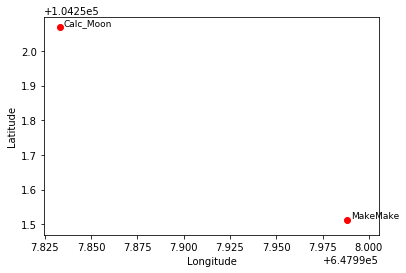

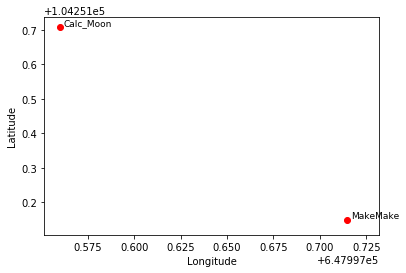

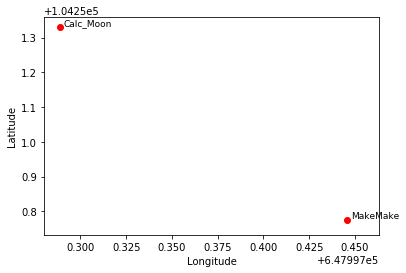

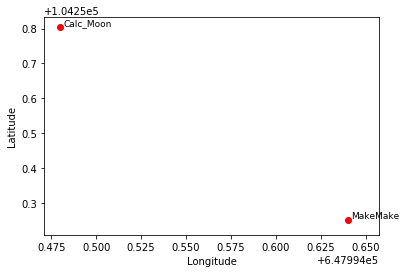

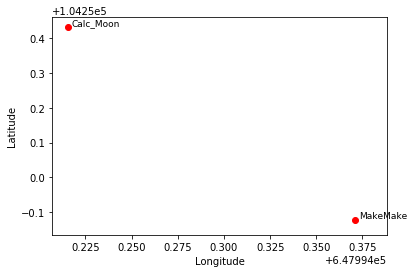

In [7]:
paramsDF = pd.read_csv('GrundyData1.csv')

convert_to_primary_centric(paramsDF,'MakeMake')

In [4]:
#This function makes a scatter plot based on the data given (x,y) data points
def plot_scatter(array,dictionary, words):
    for i in words:
            x, y = array[dictionary[i]]
            plt.scatter(x, y, color = 'red')
            if dictionary[i]==2:
                plt.text(x-0.008,y+0.012,i,fontsize=9)
            else:
                plt.text(x+0.002,y+0.006,i,fontsize=9)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()